In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

np.random.seed(42)
random_state = np.random.get_state()

In [2]:
# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
VALUES = np.zeros(7)
VALUES[1:6] = 0.5

# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
VALUES[6] = 1

# set up true state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

In [3]:
# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def temporal_difference(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]
    rewards = [0]

    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        
        # Assume all rewards are 0
        reward = 0

        trajectory.append(state)

        # TD update
        if not batch:
            values[old_state] = values[old_state] + alpha * (reward + values[state] - values[old_state])
        if state in (0, 6):
            break
        rewards.append(reward)
    
    return trajectory, rewards

In [4]:
# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]

    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)

        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break
    
    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] = values[state_] + alpha * (returns - values[state_])
    
    return trajectory, [returns] * (len(trajectory) - 1)

In [5]:
# Figure 6.2
# @method: "TD" or "MC"
def batch_updating(method, episodes, alpha=0.001):
    np.random.set_state(random_state)

    # perform 100 independent runs
    runs = 100
    total_errors = np.zeros(episodes)

    for r in trange(runs):
        current_values = np.copy(VALUES)
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for epi in range(episodes):
            if method == "TD":
                trajectory_, rewards_ = temporal_difference(current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)

            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(len(trajectory_) - 1):
                        if method == "TD":
                            updates[trajectory_[i]] = updates[trajectory_[i]] + (rewards_[i] + current_values[trajectory_[i+1]] - current_values[trajectory_[i]])
                        else:
                            updates[trajectory_[i]] = updates[trajectory_[i]] + (rewards_[i] - current_values[trajectory_[i]])
                updates *= alpha

                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        
        total_errors += np.asarray(errors)
        
    total_errors /= runs
    return total_errors

In [6]:
def figure_6_2():
    episodes = 100 + 1
    td_errors = batch_updating("TD", episodes)
    mc_errors = batch_updating("MC", episodes)

    plt.plot(td_errors, label="TD")
    plt.plot(mc_errors, label="MC")
    plt.xlabel("episodes")
    plt.ylabel("RMS error")
    plt.legend()
    plt.show()

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


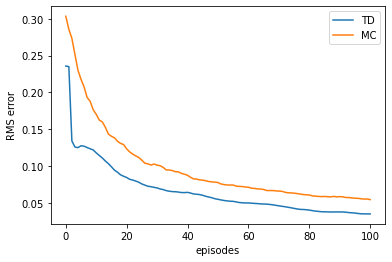

In [7]:
figure_6_2()